# Re-Implementation of the OpenLoop Plug-in in Python IFM

In [1]:
import ifm_contrib as ifm
import pandas as pd
import matplotlib.pyplot as plt

This is the simplemost benchmark. The model is a 2D model, whith an imposed hydraulic head gradient that results in a flow from West to East. An extraction well is used to remove water, which is then re-injected further downstream. The ratio of hydraulic head gradient and pumping/reinjection rate is chose in such a way, that some backflow (hydraulic shortcut) from the injection to the extraction wel will occur.

In [2]:
# load the example model
doc = ifm.loadDocument("./femdata/2D_Example.fem")

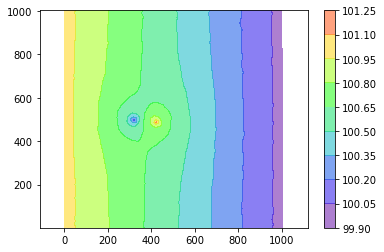

In [3]:
doc.c.plot.fringes(par=ifm.Enum.P_HEAD)
plt.colorbar()
plt.axis("equal")
None

In [4]:
# get node of injection and extraction well
n_extraction = doc.c.sel.list("extraction")[0]
n_injection = doc.c.sel.list("injection")[0]
print(f"node {n_injection} -> {n_extraction}")

node 332 -> 134


## Injection with constant temperature and flow rate

To start of simple, we first calcuate a scenario with fixed inflow temperature and flow rate.
As a heat boundary condition we use a so-called HeatLoad boundary condition, which is technically a Cauchy boundary condition with specific settings that ensures that water is injected at a certain temperature without parasitic dispersive heat flux:

+ Reference Temperature is set to the injected temperature (here: 15 deg C)
+ Transfer Rate is set to the product of flow rate and fluid heat capacity

In [5]:
# set the heat boundary condition fo

# Injection Temperature
T_inj = 15  # deg C

# Inflow Rate
Q_inj = 864.  # m³ / d

# Fluid Heat Capacity (read from element zero, assuming constant value in model)
cp_fl = doc.getParamValue(ifm.Enum.P_CAPACF, 0)

# assign the nodal transfer BC for Heat
doc.setCoupledHeatTransBndNodes([n_injection], [15.], [864. * cp_fl])

True

In [6]:
# save and run the model
doc.startSimulator()

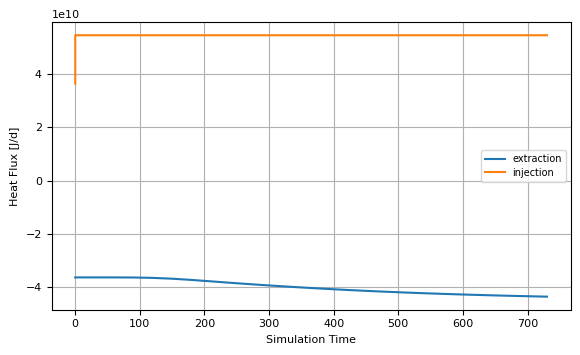

In [7]:
# check the heat balance at in and outflow
plt.style.use("DHI")
doc.c.hist.df.history(ifm.Enum.HIST_HFLUX).plot()
plt.ylabel("Heat Flux [J/d]")
plt.grid()

The plot above shows that there is a clean, constant injection of heat into the model through the injection well. This confirms that the Cauchy-BC used here prevents artificial spikes of the temperature inflow that are usually seen where a Dirichlet BC is used instead.

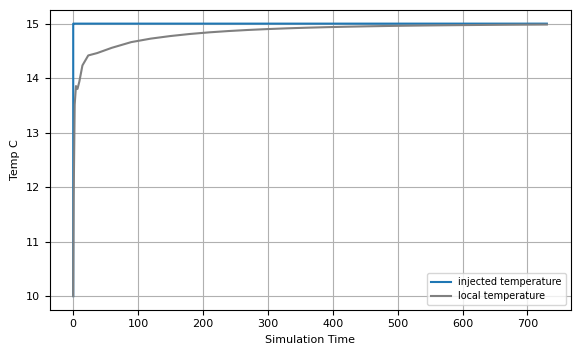

In [8]:
# check the temperature
ax1 = plt.gca()
df_temp = doc.c.hist.df.history(ifm.Enum.HIST_HFLUX) / doc.c.hist.df.history(ifm.Enum.HIST_FFLUX) / cp_fl + doc.getReferenceTemperature()
df_temp.injection.plot(ax=ax1, label="injected temperature")
doc.c.hist.df.history(ifm.Enum.HIST_LOCA_H)["2"].plot(ax=ax1, color="grey", label="local temperature")
ax1.legend()
plt.ylabel("Temp C")
plt.grid()

The injected temperature denotes the temperature of the water that is injected through the well, while the local temperature is the groundwater temperature at the node of injection. There are initially not the same, because it takes some time into the simulation until the initially cold water is sufficiently mixed with 

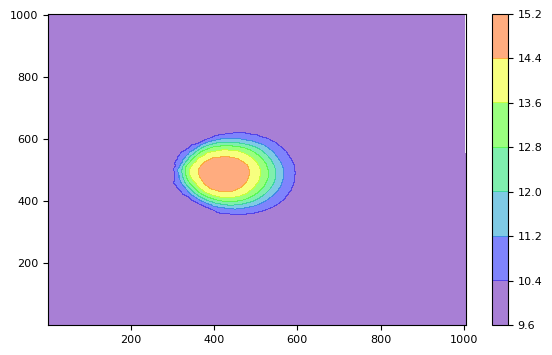

In [9]:
doc.c.plot.fringes(par=ifm.Enum.P_TEMP)
plt.colorbar()
None

At the end of the simulation period the injected water forms a bubble of water that reaches upstream towards the injection well, where a slight hydraulic shortcut occurs.

## Injection with transient temperature and flow rate

Based on the proof of concept above, a simple re-implementation of the OpenLoop Plug-in is conducted that applies the mass load boundary condition on a heat transport model.

In [10]:
# load the same model again
doc = ifm.loadDocument("./femdata/2D_waermetransport_refine_bspnodal_heat_ARE_heatload.fem")

# get node of injection and extraction well
n_extraction = doc.getSelectionItems(ifm.Enum.SEL_NODES, "extraction")[0]
n_injection = doc.getSelectionItems(ifm.Enum.SEL_NODES, "injection")[0]
print(f"node {n_extraction} -> {n_injection}")

# Fluid Heat Capacity (read from element zero, assuming constant value in model)
cp_fl = doc.getParamValue(ifm.Enum.P_CAPACF, 0)

print(f"fluid heat capacity: {cp_fl} J/m³/K")

node 134 -> 332
fluid heat capacity: 4200000.0 J/m³/K


The injected temperature is now dynamically determined from the extracted temperature (at the extraction well). The flow rate is also determined from the budget, thus that it does not need to be set (it is taken from the model automatically).

In [11]:
# set the temperature delta here
delta_t = 1  # K

def postFlowSimulation(doc, phase=1):
    """
    Callback function for FEFLOW
    This updates the boundary condition after the flow simulation has finished a time step.
    """
    
    # get flow and heat budgets at wells
    bdget = doc.budgetComputeNodal(ifm.Enum.PCLS_FLOW, [n_extraction, n_injection], True)
    q_extraction = bdget.getNodalValues()[0]
    q_injection = bdget.getNodalValues()[1]
    
    bdget = doc.budgetComputeNodal(ifm.Enum.PCLS_HEAT_TRANSPORT, [n_extraction, n_injection], True)
    h_extraction = bdget.getNodalValues()[0]
    h_injection = bdget.getNodalValues()[1]
    
    # calculate extracted temperature from budget
    t_extraction = h_extraction / q_extraction / cp_fl + doc.getReferenceTemperature()
    t_injection = t_extraction + delta_t
    
    # update the boundary condition
    doc.setCoupledHeatTransBndNodes([n_injection], [t_injection], [q_injection * cp_fl])    

In [12]:
# run the complete simulation
doc.startSimulator()

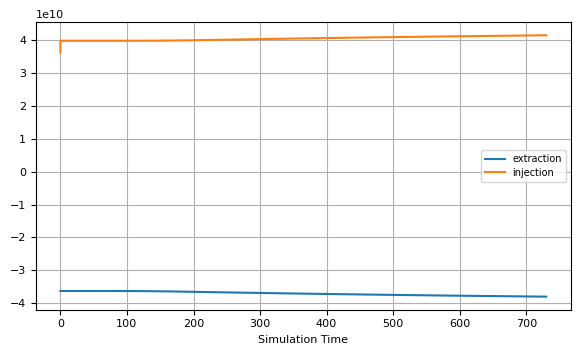

In [13]:
doc.c.hist.df.history(ifm.Enum.HIST_HFLUX).plot()
plt.grid()

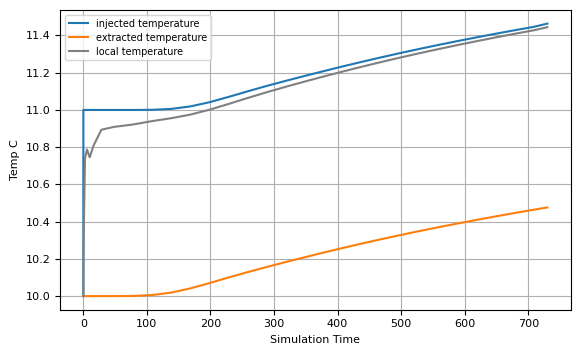

In [14]:
# plot the temperature
ax1 = plt.gca()

df_temp = doc.c.hist.df.history(ifm.Enum.HIST_HFLUX) / doc.c.hist.df.history(ifm.Enum.HIST_FFLUX) / cp_fl + doc.getReferenceTemperature()
df_temp.injection.plot(ax=ax1, label="injected temperature")
df_temp.extraction.plot(ax=ax1, label="extracted temperature")

doc.c.hist.df.history(ifm.Enum.HIST_LOCA_H)["2"].plot(ax=ax1, color="grey", label="local temperature")

ax1.legend()
plt.ylabel("Temp C")
plt.grid()

The heat balance now shows a stable line until simulation time 300 days approx. At this point, the warm plume of water reaches the extraction well, and thus that the extracted water (and thus the injected water) gets warmer.

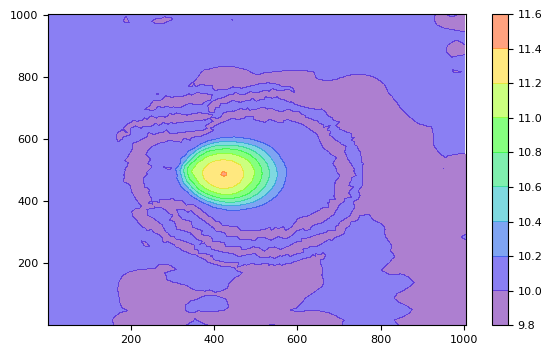

In [15]:
doc.c.plot.fringes(par=ifm.Enum.P_TEMP)
plt.colorbar()

# The PlugIn Code

The following code can be copied into the inline script in FEFLOW.

The temperature delta (first line) is set to + 1 K. The injection and extraction wells must be stored in a 
nodal selection "injection" and "extraction", respectively. Both selections must contain only a single node.
Names can be changed in the script.

The fluid heat capacity (necessary for the boudary condition forumulation) is assumed to be constant throughout the model, it will be read from element zero of the model.

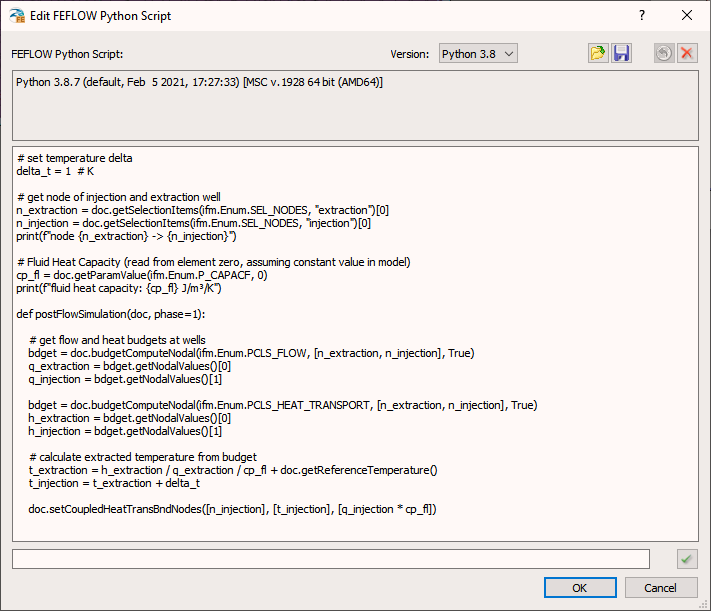


    # SET SCRIPT PARAMETERS HERE:
    delta_t = 1  # temperature delta in [K]
    selection_injection = "injection"  # name of selection that contains the injection node
    selection_extraction = "extraction"  # name of selection that contains the extraction node

    # get node of injection and extraction well
    n_extraction = doc.getSelectionItems(ifm.Enum.SEL_NODES, selection_extraction)[0]
    n_injection = doc.getSelectionItems(ifm.Enum.SEL_NODES, selection_injection)[0]
    print(f"node {n_extraction} -> {n_injection}\t")

    # Fluid Heat Capacity (read from element zero, assuming constant value in model)
    cp_fl = doc.getParamValue(ifm.Enum.P_CAPACF, 0)
    print(f"fluid heat capacity: {cp_fl} J/m³/K")

    def postFlowSimulation(doc, phase=1):

        # get flow and heat budgets at wells
        bdget = doc.budgetComputeNodal(ifm.Enum.PCLS_FLOW, [n_extraction, n_injection], True)
        q_extraction = bdget.getNodalValues()[0]
        q_injection = bdget.getNodalValues()[1]

        bdget = doc.budgetComputeNodal(ifm.Enum.PCLS_HEAT_TRANSPORT, [n_extraction, n_injection], True)
        h_extraction = bdget.getNodalValues()[0]
        h_injection = bdget.getNodalValues()[1]

        # calculate extracted temperature from budget
        t_extraction = h_extraction / q_extraction / cp_fl + doc.getReferenceTemperature()
        t_injection = t_extraction + delta_t

        doc.setCoupledHeatTransBndNodes([n_injection], [t_injection], [q_injection * cp_fl])